## Topic Indetification from the Cleaned Data

In [1]:
# !pip install textblob
# !pip install gensim
# !pip install --user pyldavis

In [1]:
import os
import time
import math
from pprint import pprint
from textblob import TextBlob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sys
import bs4
import nltk.corpus  
from nltk.text import Text
import spacy
from pandarallel import pandarallel
import multiprocessing
import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets
widgets.IntSlider()

pd.set_option('max_colwidth', 200)

import nltk as nltk
from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer
import string

import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

2023-05-22 03:46:04.089967: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 03:46:09.355870: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-22 03:46:09.357138: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [2]:
num_processors = multiprocessing.cpu_count()
num_processors

workers = num_processors-2

print(f'Using {workers} workers')

Using 62 workers


In [4]:
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

In [3]:
%%time
news_df = pd.read_parquet("data_to_sentiment.parquet", engine='pyarrow')
news_df.shape

CPU times: user 49.6 s, sys: 11.5 s, total: 1min 1s
Wall time: 1min 14s


(181958, 14)

In [7]:
news_df.head(3)

,date,month,year,quarter,day,dayofwk,title,text,title_clean,text_clean,title_tokens,text_tokens,title_len,text_len
0,2021-03-18,3,2021,2021Q1,18,3,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,\n\nArtificial intelligence improves parking efficiency in Chinese cities - People's Daily Online\n\nHome\nChina Politics\nForeign Affairs\nOpinions\nVideo: We Are China\nBusiness\nMilitary\nWorld...,Artificial intelligence improves parking efficiency Chinese cities People Daily Online,Artificial intelligence improves parking efficiency Chinese cities People Daily Online Home China Politics Foreign Affairs Opinions Video We Are China Business Military World Society Culture Trave...,"[Artificial, intelligence, improves, parking, efficiency, Chinese, cities, People, Daily, Online]","[Artificial, intelligence, improves, parking, efficiency, Chinese, cities, People, Daily, Online, Home, China, Politics, Foreign, Affairs, Opinions, Video, We, Are, China, Business, Military, Worl...",10,705
1,2020-02-27,2,2020,2020Q1,27,3,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\n...",Children With Autism Saw Their Learning Social Skills Boosted After Playing With This AI Robot News Parliament,"Children With Autism Saw Their Learning Social Skills Boosted After Playing With This AI Robot News Parliament Skip Thursday , February 27 , 2020 Latest Mansplaining conferences How forestall Drax...","[Children, With, Autism, Saw, Their, Learning, Social, Skills, Boosted, After, Playing, With, This, AI, Robot, News, Parliament]","[Children, With, Autism, Saw, Their, Learning, Social, Skills, Boosted, After, Playing, With, This, AI, Robot, News, Parliament, Skip, content, Thursday, ,, February, 27, ,, 2020, Latest, Mansplai...",17,1208
2,2021-03-26,3,2021,2021Q1,26,4,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & Rework Solutions - Dataweek","\n\nForget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & Rework Solutions - Dataweek\nHome\nAbout us\nBack issues / E-book / PDF\nEMP Handbook\nSubscribe\...","Forget ML , AI Industry 4.0 obsolescence focus 26 February 2021 Test Rework Solutions Dataweek","Forget ML , AI Industry 4.0 obsolescence focus 26 February 2021 Test Rework Solutions Dataweek Home About Back issues book PDF EMP Handbook Subscribe Advertise Categories Editor Choice Multimedia ...","[Forget, ML, ,, AI, Industry, 4.0, obsolescence, focus, 26, February, 2021, Test, Rework, Solutions, Dataweek]","[Forget, ML, ,, AI, Industry, 4.0, obsolescence, focus, 26, February, 2021, Test, Rework, Solutions, Dataweek, Home, About, us, Back, issues, book, PDF, EMP, Handbook, Subscribe, Advertise, Catego...",15,1569


In [5]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

## Applying LDA to the Titles

In [6]:
%%time
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary_title = corpora.Dictionary(news_df['title_tokens'])
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix_title = [dictionary_title.doc2bow(doc) for doc in news_df['title_tokens']]

CPU times: user 5.44 s, sys: 147 ms, total: 5.59 s
Wall time: 5.55 s


#### Tune LDA model

In [17]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=doc_term_matrix_title,
                       id2word=dictionary_title,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=list(news_df['title_tokens']), dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [19]:
%%time

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 5
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
alpha = ['symmetric'] # Run for number of topics only

# Beta parameter
beta = ['auto'] # Run for number of topics only

# Validation sets
num_of_docs = len(doc_term_matrix_title)
corpus_sets = [# gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.5), 
#                gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               doc_term_matrix_title]
# corpus_title = ['75% Corpus', '100% Corpus']
corpus_title = ['100% Corpus']
model_results_title = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary_title, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results_title['Topics'].append(k)
                model_results_title['Alpha'].append(a)
                model_results_title['Beta'].append(b)
                model_results_title['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()
                    
lda_tuning_title = pd.DataFrame(model_results_title)
lda_tuning_title.to_csv('lda_tuning_results_title.csv')

LDA will execute 6 iterations
Completed model based on 5 LDA topics. Finished 16.7% of LDA runs
Execution time to calculate for topic 5: 0hour:0min:50sec
Completed model based on 6 LDA topics. Finished 33.3% of LDA runs
Execution time to calculate for topic 6: 0hour:0min:49sec
Completed model based on 7 LDA topics. Finished 50.0% of LDA runs
Execution time to calculate for topic 7: 0hour:0min:50sec
Completed model based on 8 LDA topics. Finished 66.7% of LDA runs
Execution time to calculate for topic 8: 0hour:0min:51sec
Completed model based on 9 LDA topics. Finished 83.3% of LDA runs
Execution time to calculate for topic 9: 0hour:0min:52sec
Completed model based on 10 LDA topics. Finished 100.0% of LDA runs
Execution time to calculate for topic 10: 0hour:0min:58sec
CPU times: user 3min 52s, sys: 1min 31s, total: 5min 23s
Wall time: 5min 9s


In [21]:
lda_tuning_title = pd.read_csv('lda_tuning_results_title.csv')

In [22]:
lda_tuning_title.sort_values(by=['Coherence'], ascending=False)

,Unnamed: 0,Topics,Alpha,Beta,Coherence
2,2,7,symmetric,auto,0.315101
1,1,6,symmetric,auto,0.312984
3,3,8,symmetric,auto,0.297179
5,5,10,symmetric,auto,0.293096
0,0,5,symmetric,auto,0.292794
4,4,9,symmetric,auto,0.286985


#### Running best model

In [23]:
lda_tuning_best_title = lda_tuning_title.sort_values(by=['Coherence'], ascending=False).head(1)


tuned_topics_title = int(lda_tuning_best_title['Topics'].to_string(index=False))


# Since the values for Alpha and Beta can be float, symmetric and asymmetric, we will either strip or convert to float
try:
    tuned_alpha_title = float(lda_tuning_best_title['Alpha'].to_string(index=False))
except:
    tuned_alpha_title = lda_tuning_best_title['Alpha'].to_string(index=False).strip()
    

try:
    tuned_beta_title = float(lda_tuning_best_title['Beta'].to_string(index=False))
except:
    tuned_beta_title = lda_tuning_best_title['Beta'].to_string(index=False).strip()    
    
print(f'Best Parameters: Topics: {tuned_topics_title}, Alpha: {tuned_alpha_title}, Beta: {tuned_beta_title}')

Best Parameters: Topics: 7, Alpha: symmetric, Beta: auto


In [7]:
%%time

tuned_lda_model_title = LdaMulticore(corpus=doc_term_matrix_title,
                       id2word=dictionary_title,
                       num_topics=7,
                       random_state=100,
                       passes=10,
                       alpha='symmetric',
                       eta='auto',
                       workers = workers)

coherence_model_lda_title = CoherenceModel(model=tuned_lda_model_title, texts=news_df['title_tokens'], dictionary=dictionary_title, coherence='c_v')
coherence_lda_title = coherence_model_lda_title.get_coherence()
print('\nCoherence Score: ', coherence_lda_title)


Coherence Score:  0.2664970960197619
CPU times: user 35.5 s, sys: 15.7 s, total: 51.1 s
Wall time: 48.7 s


In [8]:
pprint(tuned_lda_model_title.print_topics())

[(0,
  '0.055*"AI" + 0.020*"intelligence" + 0.016*"News" + 0.016*"artificial" + '
  '0.009*"Artificial" + 0.008*"The" + 0.006*"Google" + 0.006*"Intelligence" + '
  '0.005*"new" + 0.005*"Business"'),
 (1,
  '0.077*"AI" + 0.014*"The" + 0.009*"News" + 0.007*"ChatGPT" + 0.005*"data" + '
  '0.004*"Microsoft" + 0.004*"New" + 0.004*"Technology" + 0.004*"How" + '
  '0.003*"India"'),
 (2,
  '0.064*"AI" + 0.021*"ChatGPT" + 0.009*"New" + 0.007*"Data" + 0.007*"Google" '
  '+ 0.006*"News" + 0.006*"new" + 0.004*"Microsoft" + 0.004*"The" + '
  '0.004*"Times"'),
 (3,
  '0.051*"AI" + 0.019*"ChatGPT" + 0.010*"The" + 0.007*"News" + 0.007*"Machine" '
  '+ 0.007*"Learning" + 0.006*"learning" + 0.005*"machine" + '
  '0.005*"intelligence" + 0.004*"Data"'),
 (4,
  '0.070*"AI" + 0.007*"Google" + 0.006*"New" + 0.006*"The" + 0.005*"Data" + '
  '0.005*"." + 0.005*"Platform" + 0.005*"How" + 0.004*"Bard" + 0.004*"News"'),
 (5,
  '0.037*"Market" + 0.035*"Intelligence" + 0.035*"Artificial" + 0.031*"AI" + '
  '0.014*"

In [9]:
%%time

lda_display_title = gensimvis.prepare(tuned_lda_model_title, doc_term_matrix_title, dictionary_title, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display_title)

CPU times: user 33.4 s, sys: 7.79 s, total: 41.2 s
Wall time: 43 s


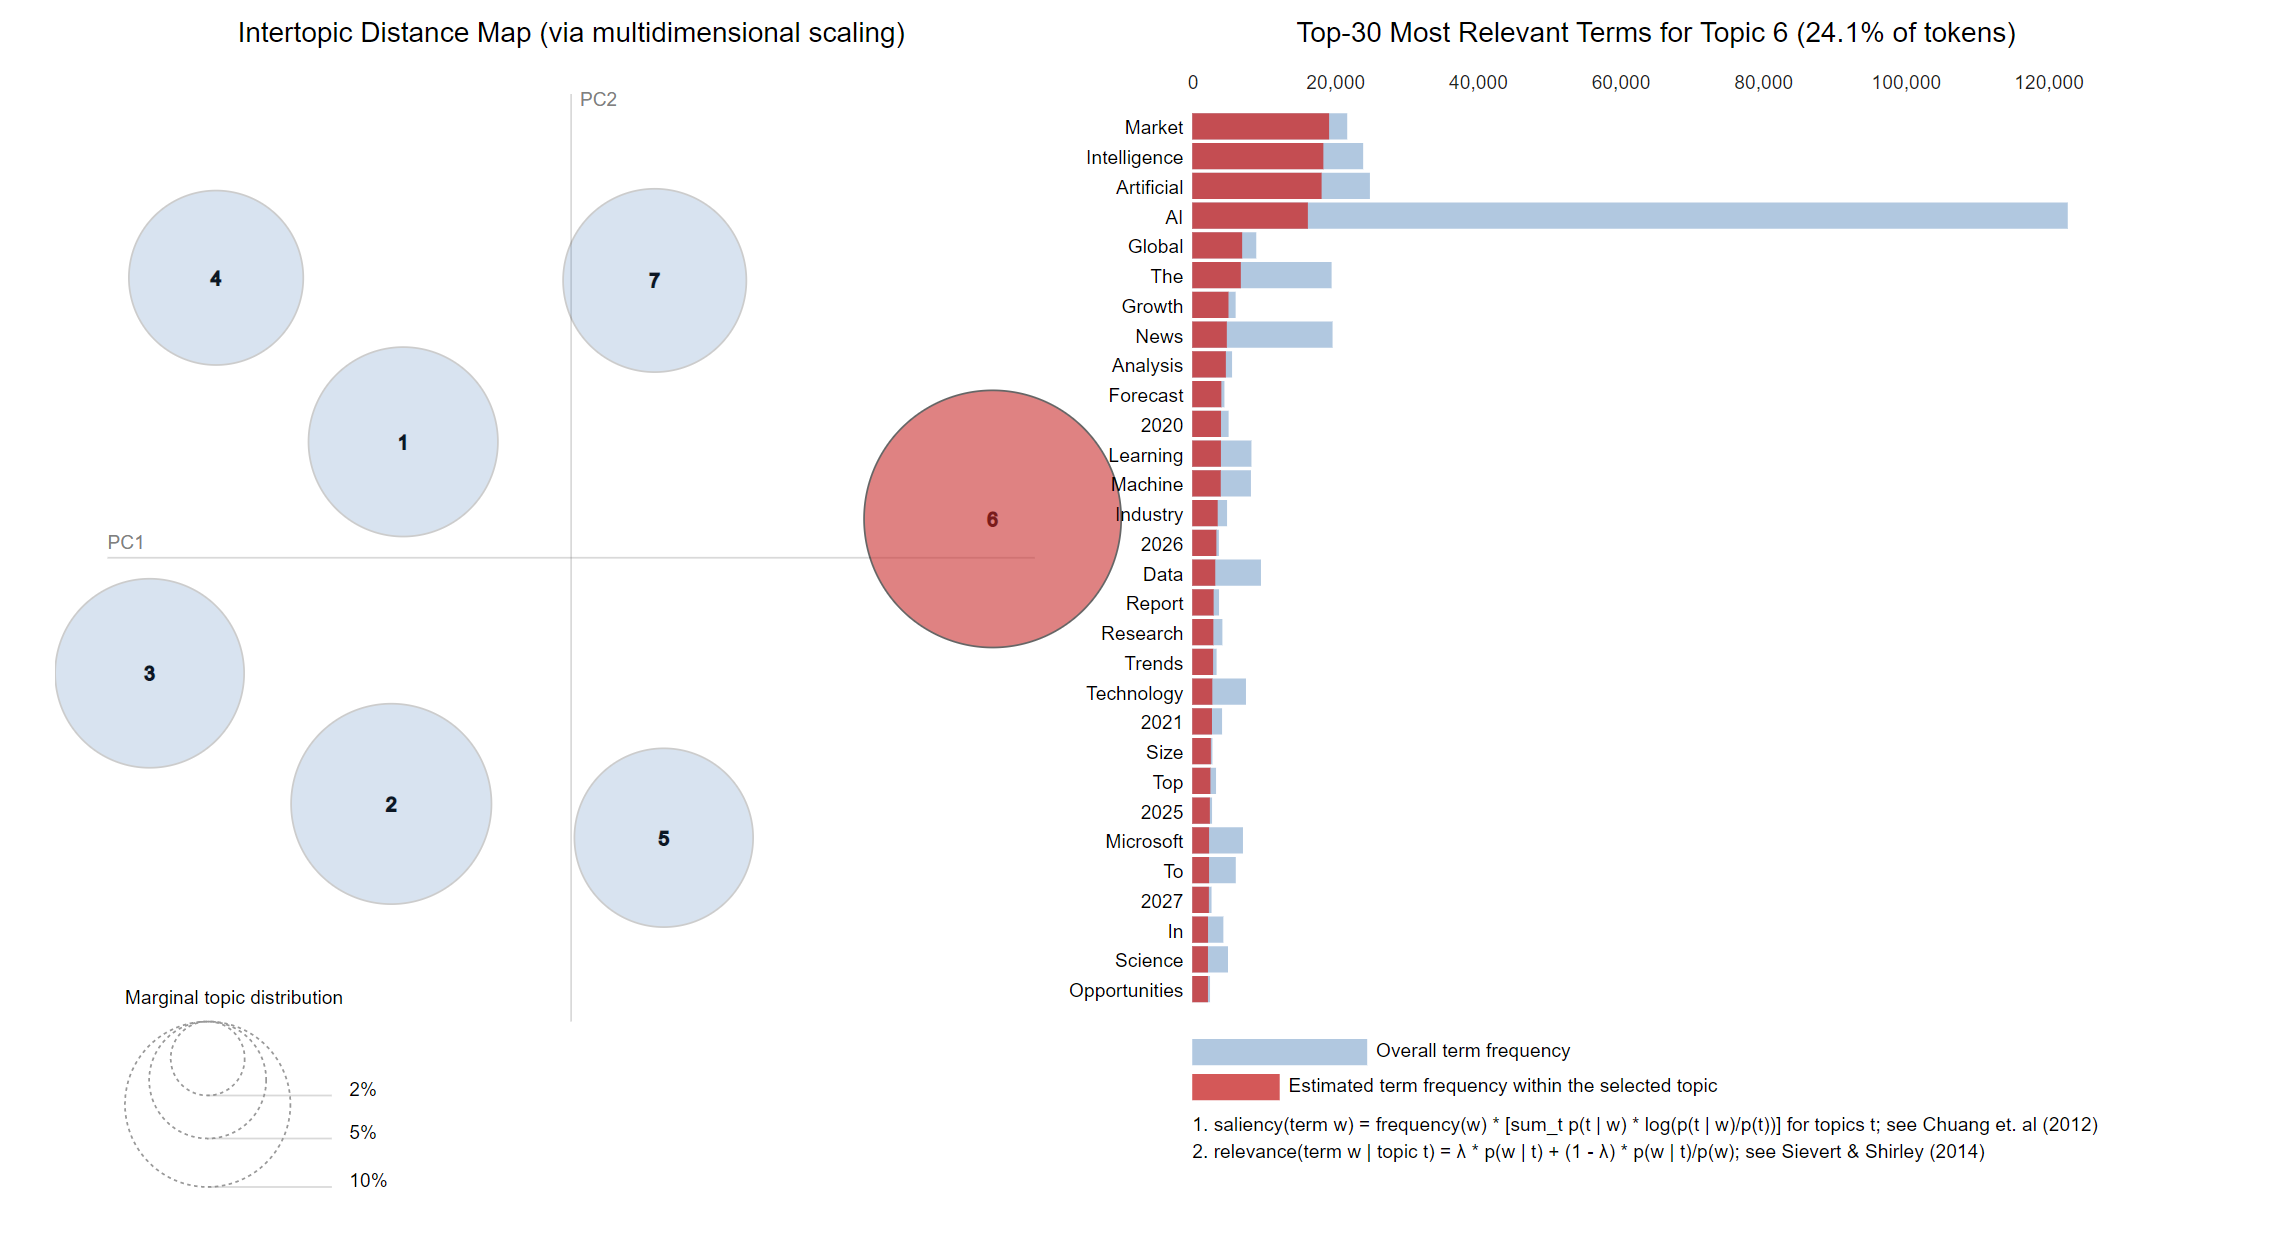

## Applying LDA on the Text
## Using the Same Model with 7 topics on Text

In [7]:
pandarallel.initialize(nb_workers = 60, use_memory_fs=False)

INFO: Pandarallel will run on 60 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [15]:
%%time
news_df['title_tokens'] = news_df['title_tokens'].parallel_apply(lambda tokens: [token for token in tokens if token != ','])
news_df['text_tokens'] = news_df['text_tokens'].parallel_apply(lambda tokens: [token for token in tokens if token != ','])


CPU times: user 36.1 s, sys: 26.4 s, total: 1min 2s
Wall time: 1min 1s


In [20]:
news_df.to_parquet('data_to_sentiment.parquet')

In [16]:
%%time
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary_text = corpora.Dictionary(news_df['text_tokens'])
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix_text = [dictionary_text.doc2bow(doc) for doc in news_df['text_tokens']]

CPU times: user 5min 16s, sys: 4.14 s, total: 5min 20s
Wall time: 5min 20s


In [ ]:
%%time

tuned_lda_model_text = LdaMulticore(corpus=doc_term_matrix_text,
                       id2word=dictionary_text,
                       num_topics=7,
                       random_state=100,
                       passes=10,
                       alpha='symmetric',
                       eta='auto',
                       workers = workers)

coherence_model_lda_text = CoherenceModel(model=tuned_lda_model_text, texts=news_df['text_tokens'], dictionary=dictionary_text, coherence='c_v')
coherence_lda_text = coherence_model_lda_text.get_coherence()
print('\nCoherence Score: ', coherence_lda_text)

In [ ]:
pprint(tuned_lda_model_text.print_topics())

In [ ]:
%%time

lda_display_text = gensimvis.prepare(tuned_lda_model_text, doc_term_matrix_text, dictionary_title, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display_text)